In [2]:
import torch
from torchvision import transforms
import torchstain
import cv2
import matplotlib.pyplot as plt
import os, glob
import numpy as np

### 1. Color Normalization

In [19]:
DIR = '/Users/salma/Desktop/Leuk/data/val/'
OUT = '/Users/salma/Desktop/Leuk/data/val_color_normalized/'

#if OUT directory does not exist, create it
if not os.path.exists(OUT):
    os.makedirs(OUT)

In [20]:
#reference image
target = cv2.cvtColor(cv2.imread("/Users/salma/Desktop/Leuk/data/train/ALL/Image_4184.png"), cv2.COLOR_BGR2RGB)

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
normalizer.fit(T(target))

In [21]:
# Walk through all the subdirectories in DIR
for subdir, dirs, files in os.walk(DIR):
    for filename in files:
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            filepath = os.path.join(subdir, filename)
            to_transform = cv2.cvtColor(cv2.imread(os.path.join(filepath)), cv2.COLOR_BGR2RGB)
            t_to_transform = T(to_transform)
            norm, H, E = normalizer.normalize(I=t_to_transform, stains=True)
            #save H image
            H = np.array(H)
            E = np.array(E)
            norm = np.array(norm)
            file_noext = os.path.splitext(filename)[0]
            s = os.path.relpath(subdir, DIR)
            out_path = os.path.join(OUT, s)
            os.makedirs(out_path, exist_ok=True)  # Create output subdir if not exists
            cv2.imwrite(os.path.join(out_path, file_noext) + ".png", norm)

### 2. Resise to 448 x 448

In [17]:
def resize_images(root_dir, output_dir, size=(448, 448)):
    for subdir, dirs, files in os.walk(root_dir):
        for filename in files:
            # Check for image file extensions
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                # Construct the full file path
                filepath = os.path.join(subdir, filename)
                # Read the image
                image = cv2.imread(filepath)
                # Resize the image
                resized_image = cv2.resize(image, size)
                # Construct the output path, maintaining the directory structure
                out_path = os.path.join(output_dir, os.path.relpath(subdir, root_dir))
                # Make sure the directory exists
                os.makedirs(out_path, exist_ok=True)
                # Save the image
                cv2.imwrite(os.path.join(out_path, filename), resized_image)

In [48]:
# Define the directories
DIR = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'
OUT = '/Users/salma/Desktop/Leuk/data/val_norm_mask_resized/'
if not os.path.exists(OUT):
    os.makedirs(OUT)
    
resize_images(DIR, OUT)

### 4. Re-naming Masks

In [47]:
# Define the root directory where the subfolders are located.
root_directory = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

# Walk through the directory structure.
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if the current file matches the pattern with '.png' in the middle.
        if file.endswith(".png_mask.png"):
            # Define the old and new file paths.
            old_file_path = os.path.join(subdir, file)
            new_file_path = old_file_path.replace(".png_mask.png", "_mask.png")

            # Rename the file.
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{old_file_path}' to '{new_file_path}'")


Renamed '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_5.png_mask.png' to '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_5_mask.png'
Renamed '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_19.png_mask.png' to '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_19_mask.png'
Renamed '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_13.png_mask.png' to '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_13_mask.png'
Renamed '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_8.png_mask.png' to '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44201231857A_8_mask.png'
Renamed '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44-23-124-0339 - 3.png_mask.png' to '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed/ALL_mask/44-23-124-0339 - 3_mask.png'
Renamed '/Use

### 4. Mask Overlay

In [57]:
import cv2
import os
import numpy as np

def apply_mask(image_path, mask_path, output_path):
    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image and mask sizes are equal
    if image.shape[:2] != mask.shape:
        raise ValueError("The size of the image does not match the size of the mask.")

    # Apply the mask: keep the image where the mask is 1, else set to black
    result = cv2.bitwise_and(image, image, mask=mask)

    # Save the result
    cv2.imwrite(output_path, result)

def process_folders(images_folder, masks_folder, output_folder):
    # Iterate over the subfolders in the images folder
    for class_folder in os.listdir(images_folder):
        class_path = os.path.join(images_folder, class_folder)
        mask_class_path = os.path.join(masks_folder, class_folder)
        output_class_path = os.path.join(output_folder, class_folder)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Iterate over the images in the subfolder
        for image_name in os.listdir(class_path):
            if not image_name.endswith("_mask.png"):  # Ignore mask files
                image_path = os.path.join(class_path, image_name)
                mask_name = f"{os.path.splitext(image_name)[0]}_mask.png"
                mask_path = os.path.join(mask_class_path, mask_name)
                if os.path.exists(mask_path):
                    output_path = os.path.join(output_class_path, image_name)
                    apply_mask(image_path, mask_path, output_path)
                else:
                    print(f"Mask not found for {image_name}")

# Example usage
images_folder = '/Users/salma/Desktop/Leuk/data/val_color_normalized_resized'
masks_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_resized'
output_folder = './overlayed_val'
# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_folders(images_folder, masks_folder, output_folder)

In [3]:
import cv2
import os
import numpy as np

def apply_mask(image_path, mask_path, output_path, background_color='white'):
    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image and mask sizes are equal
    if image.shape[:2] != mask.shape:
        raise ValueError("The size of the image does not match the size of the mask.")

    # Apply the mask: keep the image where the mask is 1, else set to background color
    foreground = cv2.bitwise_and(image, image, mask=mask)
    
    # Create an inverse mask to change the background
    inverse_mask = cv2.bitwise_not(mask)
    
    # Prepare the background color image
    if background_color == 'white':
        background = np.full(image.shape, 255, dtype=np.uint8)  # White background
    else:
        background = np.zeros(image.shape, dtype=np.uint8)  # Black background

    # Apply inverse mask to the background image
    background = cv2.bitwise_and(background, background, mask=inverse_mask)

    # Combine the foreground and background
    result = cv2.add(foreground, background)

    # Save the result
    cv2.imwrite(output_path, result)

def process_folders(images_folder, masks_folder, output_folder):
    # Iterate over the subfolders in the images folder
    for class_folder in os.listdir(images_folder):
        class_path = os.path.join(images_folder, class_folder)
        mask_class_path = os.path.join(masks_folder, class_folder)
        output_class_path = os.path.join(output_folder, class_folder)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Iterate over the images in the subfolder
        for image_name in os.listdir(class_path):
            if not image_name.endswith("_mask.png"):  # Ignore mask files
                image_path = os.path.join(class_path, image_name)
                mask_name = f"{os.path.splitext(image_name)[0]}_mask.png"
                mask_path = os.path.join(mask_class_path, mask_name)
                if os.path.exists(mask_path):
                    output_path = os.path.join(output_class_path, image_name)
                    apply_mask(image_path, mask_path, output_path)
                else:
                    print(f"Mask not found for {image_name}")

# Example usage
images_folder = '/Users/salma/Desktop/Leuk/data/train_color_normalized_resized'
masks_folder = '/Users/salma/Desktop/Leuk/data/generated_train_masks'
output_folder = './overlayed_train_w'
# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_folders(images_folder, masks_folder, output_folder)

### 4. Convert Mask to Binary

In [35]:
root_directory = '/Users/salma/Desktop/Leuk/data/val_seg_masks_resized'
out_dir = '/Users/salma/Desktop/Leuk/data/val_seg_masks_gray'
# Walk through the directory structure.
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if the current file matches the pattern with '.png' in the middle.
        if file.endswith(".png"):
            img = cv2.imread(os.path.join(subdir, file))
            #make image between 0 and 1
            gray = img / 255
            # plt.hist(gray.ravel())
            # plt.show()

            # #convert to grayscale
            # #clip values above 250
            # gray = np.clip(img, 1, 250)
            # #print unqiue values of the image
            # print(np.unique(img))
            # break
            # # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # # plt.hist(gray.ravel())
            # # plt.show()
            # # Save the image in the output directory.
            out_path = os.path.join(out_dir, os.path.relpath(subdir, root_directory))
            os.makedirs(out_path, exist_ok=True)
            cv2.imwrite(os.path.join(out_path, file), gray)



root_directory = '/Users/salma/Desktop/Leuk/data/val_seg_masks_resized'
out_dir = '/Users/salma/Desktop/Leuk/data/val_seg_masks_gray'
# Walk through the directory structure.
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if the current file matches the pattern with '.png' in the middle.
        if file.endswith(".png"):
            #convert to grayscale
            img = cv2.imread(os.path.join(subdir, file))
            #
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Save the image in the output directory.
            out_path = os.path.join(out_dir, os.path.relpath(subdir, root_directory))
            os.makedirs(out_path, exist_ok=True)
            cv2.imwrite(os.path.join(out_path, file), gray)



### 3. Improve Contrast

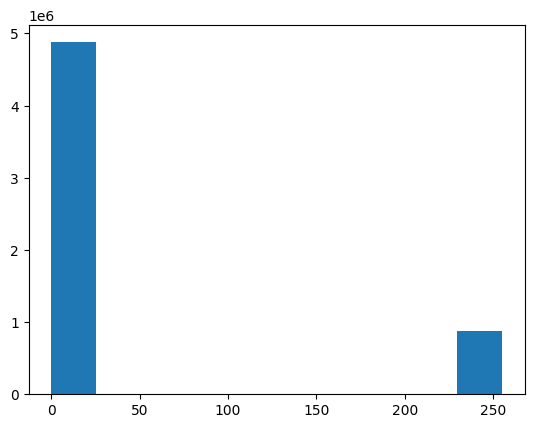

In [36]:
#print histogram of pixel values image 2
img = cv2.imread('/Users/salma/Desktop/Leuk/data/val_mask_seg/44221290379A_49_mask.png')
plt.hist(img.ravel())
plt.show()


In [119]:
import cv2
import numpy as np
import os
from pathlib import Path
from PIL import Image, ImageFilter

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Fill holes using morphological closing operation
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size if necessary
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    #smoothen the edges
    closed_image = cv2.GaussianBlur(closed_image, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)

    # Save the processed image
    cv2.imwrite(output_path, closed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [120]:
import cv2
import numpy as np
import os

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def findBiggestContour(contours):
    max_area = 0
    index = -1
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            index = i
    return index

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a binary image where white represents the skin tone range
    skin_mask = cv2.inRange(hsv_image, (0, 48, 80), (20, 255, 255))

    # Find contours
    contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest contour
    s = findBiggestContour(contours)

    # Draw the biggest contour
    output = np.zeros_like(skin_mask)
    cv2.drawContours(output, contours, s, 255, -1, 8, hierarchy, 0)

    # Save the processed image
    cv2.imwrite(output_path, output)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [121]:
import cv2
import numpy as np
import os

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Detect edges
    edges = cv2.Canny(binary_image, 100, 200)

    # Dilate and erode the edges to smooth them
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    smoothed_edges = cv2.erode(dilated_edges, kernel, iterations=1)

    # Combine the smoothed edges with the original binary image
    smoothed_image = cv2.bitwise_or(binary_image, smoothed_edges)

    # Save the processed image
    cv2.imwrite(output_path, smoothed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [124]:
import cv2
import numpy as np
import os
from pathlib import Path
from PIL import Image, ImageFilter

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Fill holes using morphological closing operation
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size if necessary
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    #smoothen the edges
    closed_image = cv2.GaussianBlur(closed_image, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)

    edges = cv2.Canny(closed_image, 100, 200)

    # Step 2: Dilate the edges to make them thicker
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Step 3: Apply Gaussian blur to the dilated edges to smoothen them
    smoothed_edges = cv2.GaussianBlur(dilated_edges, (5, 5), 0)

    # Step 4: Add the smoothed edges back to the original image to maintain the edge locations
    smoothed_image = cv2.bitwise_or(closed_image, smoothed_edges)

    # Step 5: Threshold the image again to ensure it is binary
    _, smoothed_binary_image = cv2.threshold(smoothed_image, 1, 255, cv2.THRESH_BINARY)

    # Save the processed image
    cv2.imwrite(output_path, smoothed_binary_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [126]:
import os

# Define the root directory where the subfolders are located.
root_directory = '/Users/salma/Desktop/Leuk/data/val_norm_seg'

# Walk through the directory structure.
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if the current file matches the pattern with '.png' in the middle.
        if file.endswith(".png_mask.png"):
            # Define the old and new file paths.
            old_file_path = os.path.join(subdir, file)
            new_file_path = old_file_path.replace(".png_mask.png", "_mask.png")

            # Rename the file.
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{old_file_path}' to '{new_file_path}'")


In [122]:
import cv2
import numpy as np
import os
from pathlib import Path

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Detect edges
    edges = cv2.Canny(binary_image, 100, 200)

    # Dilate the edges to make them more prominent
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Apply Gaussian blur to smooth the edges
    smoothed_edges = cv2.GaussianBlur(dilated_edges, (5, 5), 0)

    # Combine the smoothed edges with the binary image
    result_image = cv2.bitwise_or(binary_image, smoothed_edges)

    # Fill holes using morphological closing operation
    closed_image = cv2.morphologyEx(result_image, cv2.MORPH_CLOSE, kernel)

    # Save the processed image
    cv2.imwrite(output_path, closed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.
